In [1]:
#SYSID


In [2]:
import numpy as np
import time
import pandas as pd
import matplotlib.pyplot as plt
import random
import json
from gekko import GEKKO


In [53]:
df2=pd.read_excel('CC_74869-184828.xlsx',header=0,index_col=0)
df2.columns = [ 'F', 'FW', 'P', 'MS', 'BP1_only','SW','SL','D','PS','CP','BP','D50'] ### *** change depend on data set

df0=df2.copy()

In [65]:
df6 = df0[#(df0['F'] >= 0 )& (df0['Feed'] < 1600) &
          #(df0['FW'] >= 0.01 )&
          #(df0['SW'] >= 0.01 )&
         (df0['MS'] > 1)]# &
          #(df0['PS']>= 50)&
          #(df0['CP']>= 0.01)& #all
          #(df0['P']> 0)&
         #(df0['BP']> 0)&
         #(df0['D']> 15)&
         #(df0['D50']< 5.0 )] #all
print('new data set len',len(df6),'diff',len(df6)-len(df0))
print('without cutting outlier data, modeling is difficult.')

new data set len 104934 diff -5026
without cutting outlier data, modeling is difficult.


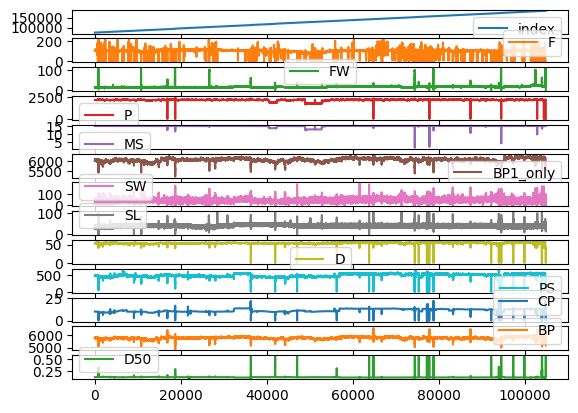

In [59]:
train=df6.reset_index()
train.plot(subplots=True)
plt.show()

In [61]:
# MV = ['F', 'FW', 'MS', 'SW', 'PS']
# CV = ['BP', 'P', 'SL', 'D', 'CP', 'D50']
MV = ['F','FW','MS','SL','CP']
CV = ['BP','P','D','D50']

train=train.clip(0.01)
#train['MS'].clip(1,inplace=True)
train.drop('index',axis=1)
train=train.reset_index()


In [62]:
#If desired to exclude certain correlations can do individually per CV, then concatenate. 

from gekko import GEKKO
t = train['index']
u = train[MV]   #DIFFERENT, NEW NEW
y = train[CV]

# generate time-series model
m = GEKKO()

##################################################################
# system identification
na = 2 # output coefficients
nb = 4 # input coefficients
print('Identify model')
yp,p,K = m.sysid(t,u,y,na,nb,objf=10000,scale=True,diaglevel=1,pred='meas')#,shift='none')

Identify model
---Final---
Gain
[[ 0.41697784 -0.12274909 -0.19321749  0.06787907  0.3117288 ]
 [-0.00439499  0.0155689   1.0053812  -0.0087694   0.00701715]
 [ 0.32247819 -0.0101503  -0.14578782 -0.00626543  0.12872563]
 [-0.03618551 -0.01742561  0.03599053  0.05057893 -0.04720564]]
alpha
[[0.69240075 0.33076971 0.55055693 0.48697291]
 [0.23867589 0.39658054 0.34590833 0.39827704]]
beta
[[[ 1.21895901e-01  2.84086168e-01  1.45747754e+01  7.29906250e-02
    3.16814067e+00]
  [ 6.61497020e-02 -6.49371856e-01 -4.14814784e+00 -7.18172979e-02
   -2.69357381e+00]
  [ 6.35881747e-03 -6.29753508e-01 -6.98764002e+00  9.52105722e-02
    1.50631690e+00]
  [ 3.61675091e-02  8.64215623e-01 -5.05774294e+00 -1.90783962e-02
   -4.47616166e-01]]

 [[-6.81789225e-03 -8.14969081e-02 -2.68313866e+01 -8.03833669e-02
   -2.21393946e+00]
  [-2.53092535e-02  3.52585202e-01  1.56509801e+01  7.85260814e-02
    4.60835338e+00]
  [ 3.92690230e-02  1.79163134e+00  3.07491560e+01 -8.28658355e-02
   -4.28327393e+00

In [72]:
import pickle
#p = {'a':A,'b':B,'c':C} #run to save
with open('p_gek_5_4_cut_MS.pkl', 'wb') as file:
    pickle.dump(p, file)

In [73]:
with open('p_gek_5_4_cut_MS.pkl', 'rb') as file:   # na=2 nb=4
    p = pickle.load(file)

#new p array: ARX coefficients
MV=['F','FW','MS','SL','CP']
CV=['BP','P','D','D50']

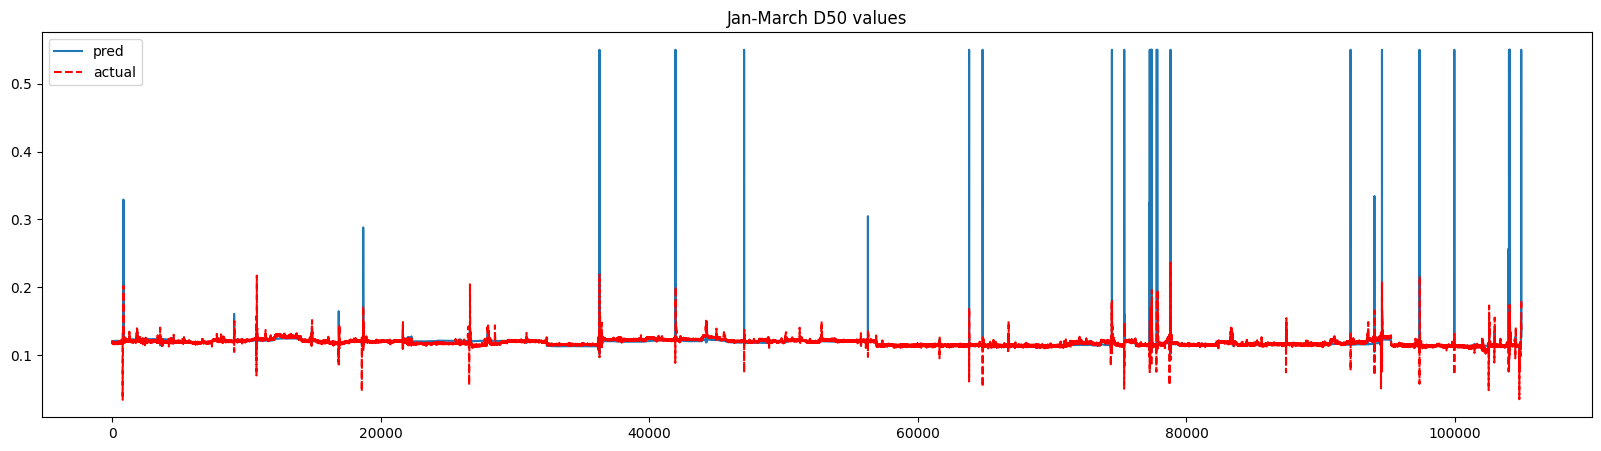

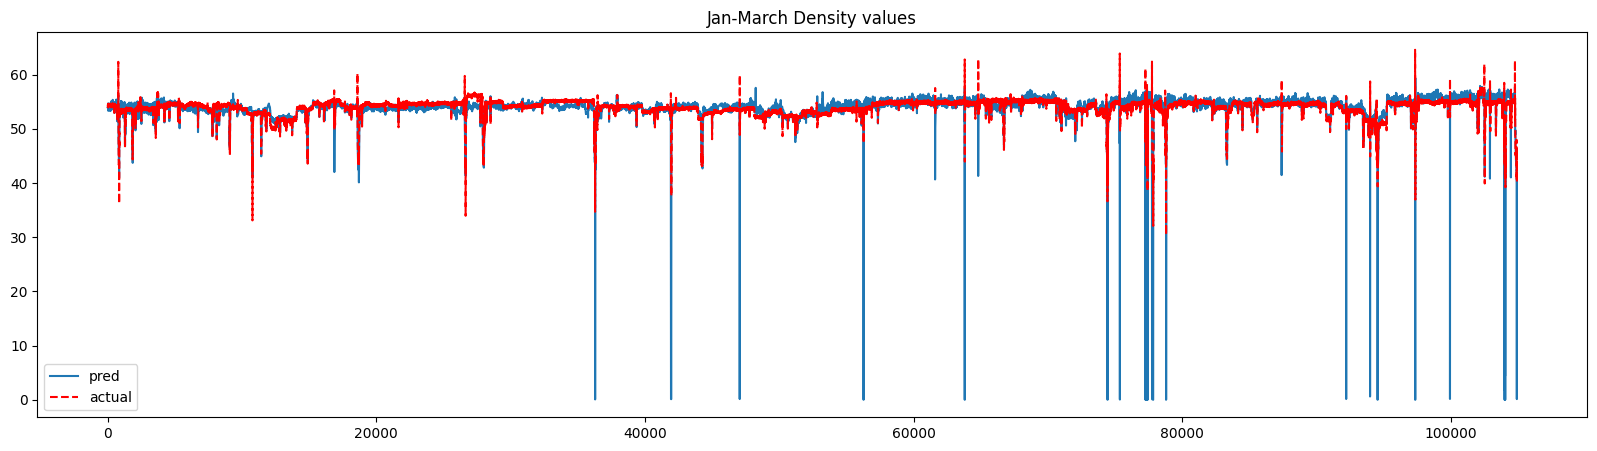

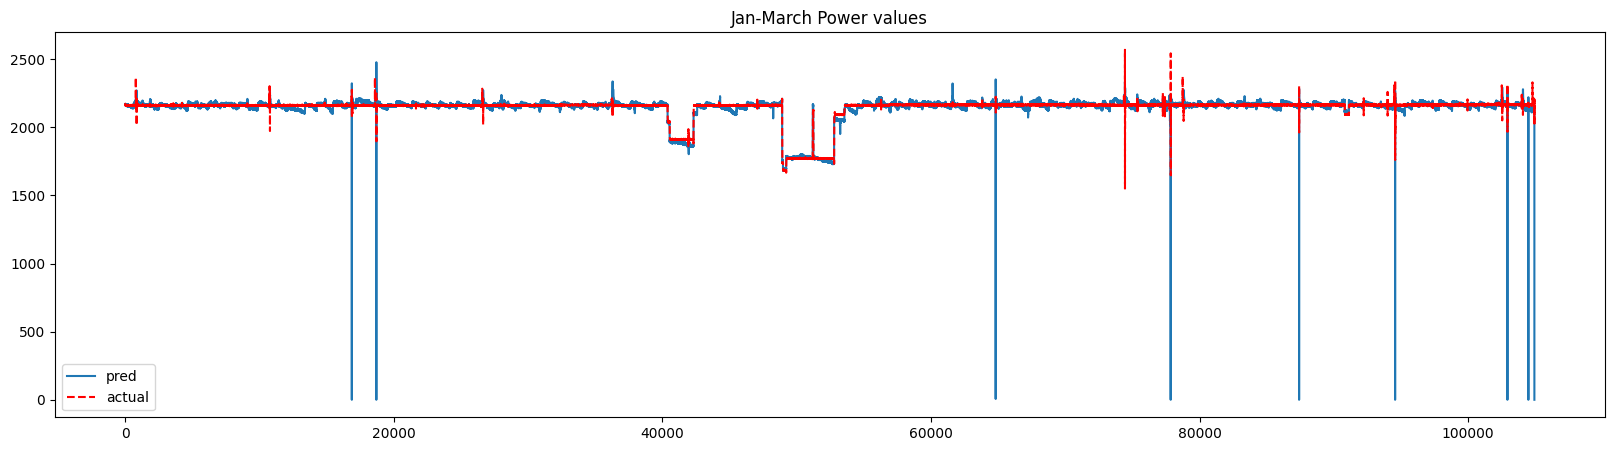

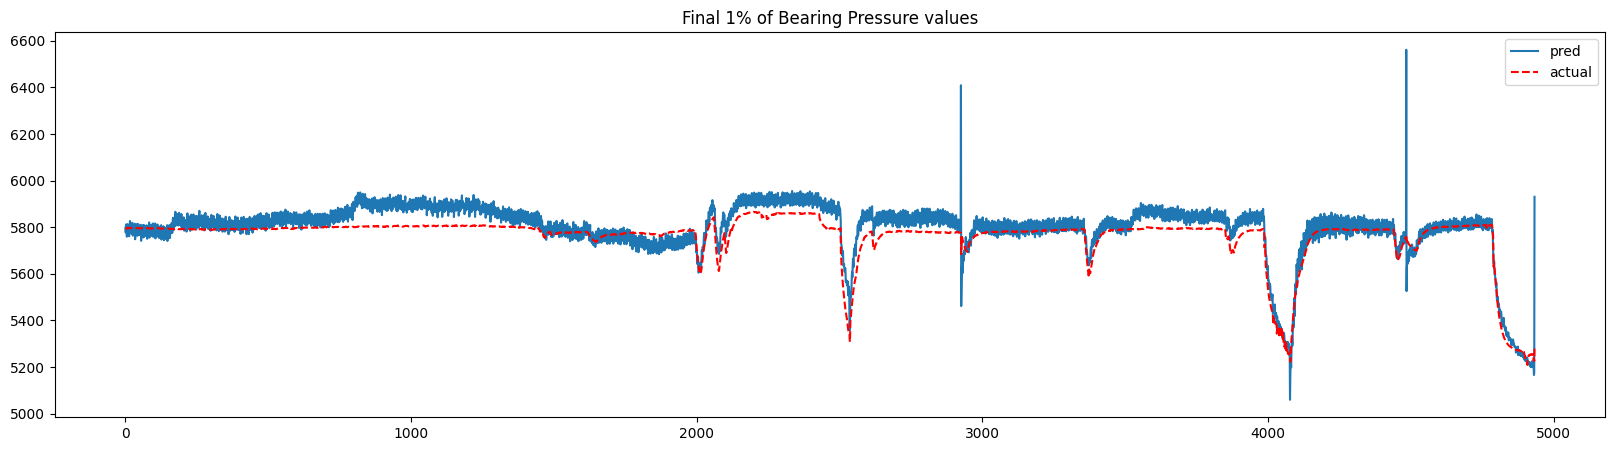

In [68]:
df=train.copy()

plt.figure(0,figsize=(20,5))
plt.title('Jan-March D50 values')

plt.plot(df[CV[-1]].to_numpy())
plt.plot(yp[:, len(CV)-1],'r--')
plt.legend(['pred','actual']);
plt.show()

plt.figure(2,figsize=(20,5))
plt.title('Jan-March Density values')

plt.plot(df[CV[-2]].iloc[:].to_numpy())
plt.plot(yp[:, len(CV)-2],'r--')
plt.legend(['pred','actual']);
plt.show()

plt.figure(2,figsize=(20,5))
plt.title('Jan-March Power values')

plt.plot(df[CV[-3]].iloc[:].to_numpy())
plt.plot(yp[:, len(CV)-3],'r--')
plt.legend(['pred','actual']);
plt.show()

plt.figure(2,figsize=(20,5))
plt.title('Final 1% of Bearing Pressure values')

plt.plot(df[CV[-4]].iloc[100000:].to_numpy())
plt.plot(yp[100000:, len(CV,)-4],'r--')
plt.legend(['pred','actual']);
plt.show()

In [20]:
#sum(yp[:, len(CV)-1] )- (df[CV[-1]].to_numpy() )/len(df)
14815/len(df)

0.1347308112040742

In [8]:
# import pickle 
# #p = {'a':A,'b':B,'c':C}   #run to save.
# with open('p_gek_5_4_all.pkl', 'wb') as file:
#     pickle.dump(p, file)

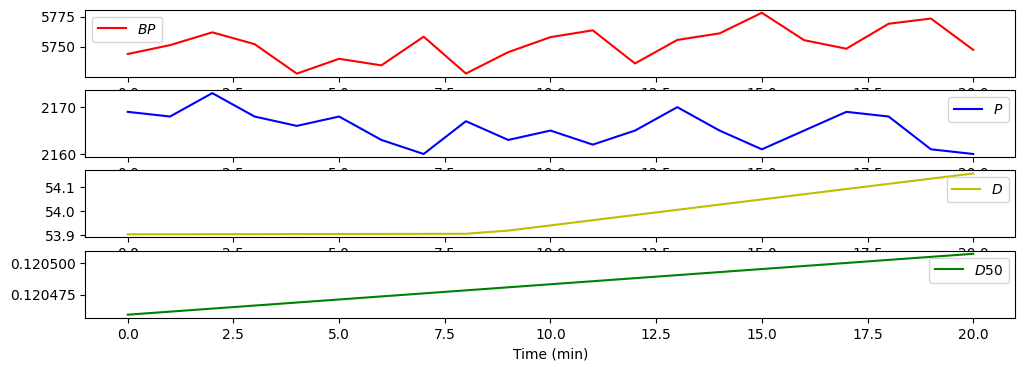

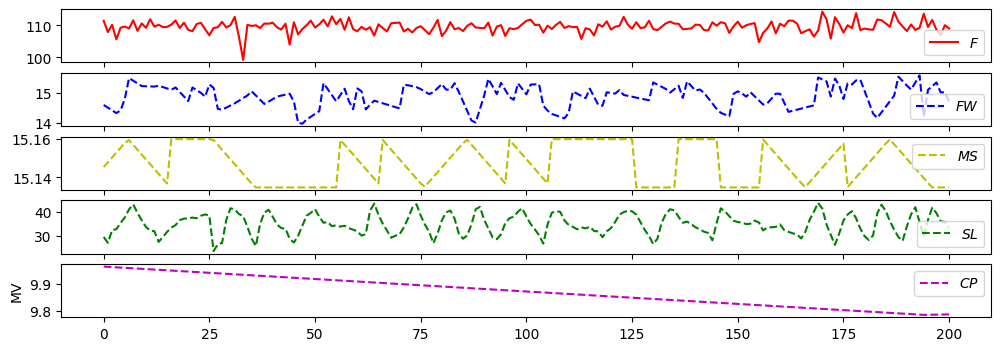

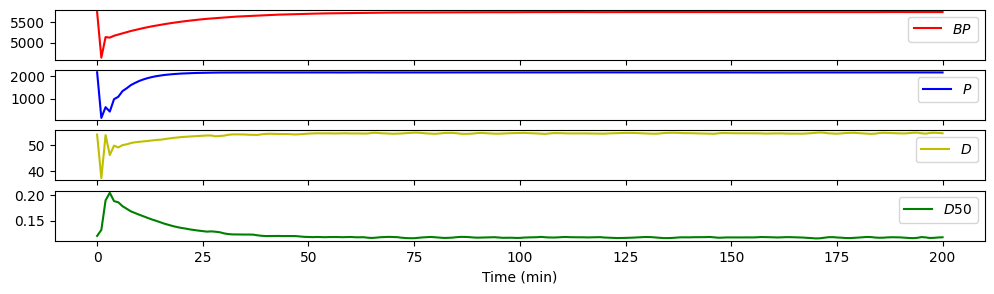

In [87]:
# DIY FULL ARX
 
# Could try scaling differently so coefficients are reasonable
# Try different variable.

MV = ['F','FW','MS','SL','CP']
CV = ['BP','P','D','D50']

na = 2 # Number of A coefficients
nb = 4 # Number of B coefficients
ny = 4 # Number of outputs
nu = 5 # Number of inputs

# A (na x ny)
# B (ny x (nb x nu))
# C (ny)
#p is above

# Create GEKKO model
sm = GEKKO(remote=False)

# Build GEKKO ARX model
sy = sm.Array(sm.CV,4)
su = sm.Array(sm.MV,5)

df=train.copy()

for i in range(len(sy)):
    sy[i].value=df[CV[i]].iloc[0]

sy,su = sm.arx(p,sy,su)

# load inputs
tf = 20 # final time
u1 = np.zeros(tf+1)
u2 = u1.copy()
u3 = u2.copy()
u4 = u3.copy()
u5 = u4.copy()

# u1[:] = df_5[MV[0]].median()
# u2[:] = df_5[MV[1]].median()
# u3[:] = df_5[MV[2]].median()
# u4[:] = df_5[MV[3]].median()
# u5[:] = df_5[MV[4]].median()

u1[0:] = df[MV[0]].iloc[0:tf+1]
u2[0:] = df[MV[1]].iloc[0:tf+1]
u3[0:] = df[MV[2]].iloc[0:tf+1]
u4[0:] = df[MV[3]].iloc[0:tf+1]
u5[0:] = df[MV[4]].iloc[0:tf+1]

su[0].value = u1
su[1].value = u2
su[2].value = u3
su[3].value = u4
su[4].value = u5

# customize names
mv1 = su[0]; mv2 = su[1]; mv3 = su[2]; mv4 = su[3]; mv5 = su[4]
cv1 = sy[0]; cv2 = sy[1]; cv3 = sy[2]; cv4 = sy[3]; #cv5 = sy[4]; cv6 = sy[5]


# options
sm.time = np.linspace(0,tf,tf+1)
sm.options.imode = 4; sm.options.nodes = 2

# simulate
sm.solve(disp=False)
#m.time=m.time[20:]
plt.figure(0,figsize=(12,4))
#plt.title('MV Moves');
plt.subplot(5,1,1)
plt.plot(sm.time,mv1.value,'r-',label=r'$F$');plt.legend(loc='best')
plt.subplot(5,1,2)
plt.plot(sm.time,mv2.value,'b--',label=r'$FW$');plt.legend(loc='best')
plt.subplot(5,1,3)
plt.plot(sm.time,mv3.value,'y--',label=r'$MS$');plt.legend(loc='best')
plt.subplot(5,1,4)
plt.plot(sm.time,mv4.value,'g--',label=r'$SL$');plt.legend(loc='best')
plt.subplot(5,1,5)
plt.plot(sm.time,mv5.value,'m--',label=r'$CP$');plt.legend(loc='best')
plt.ylabel('MV')
plt.legend(loc='best')
plt.show();

plt.figure(1,figsize=(12,3));
#plt.title('Simulated Response');
plt.subplot(4,1,1)
plt.plot(sm.time,cv1.value,'r-',label=r'$BP$');plt.legend(loc='best')
plt.subplot(4,1,2)
plt.plot(sm.time,cv2.value,'b-',label=r'$P$');plt.legend(loc='best')
plt.subplot(4,1,3)
plt.plot(sm.time,cv3.value,'y-',label=r'$D$');plt.legend(loc='best')
plt.subplot(4,1,4)
plt.plot(sm.time,cv4.value,'g-',label=r'$D50$');plt.legend(loc='best')
# plt.subplot(6,1,5)
# plt.plot(sm.time,cv5.value,'m-',label=r'$CP$');plt.legend(loc='best')
# plt.subplot(6,1,6)
# plt.plot(sm.time,cv6.value,'c-',label=r'$D50$'); 
plt.xlabel('Time (min)');
plt.show();

plt.figure(2,figsize=(12,4));
#plt.title('Real Response');
plt.subplot(4,1,1)
plt.plot(sm.time,df[CV[0]].iloc[:tf+1],'r-',label=r'$BP$');plt.legend(loc='best')
plt.subplot(4,1,2)
plt.plot(sm.time,df[CV[1]].iloc[:tf+1],'b-',label=r'$P$');plt.legend(loc='best')
plt.subplot(4,1,3)
plt.plot(sm.time,df[CV[2]].iloc[:tf+1],'y-',label=r'$D$');plt.legend(loc='best')
plt.subplot(4,1,4)
plt.plot(sm.time,df[CV[3]].iloc[:tf+1],'g-',label=r'$D50$');plt.legend(loc='best')
# plt.subplot(6,1,5)
# plt.plot(sm.time,df[CV[4]].iloc[:tf+1],'m-',label=r'$CP$');plt.legend(loc='best')
# plt.subplot(6,1,6)
# plt.plot(sm.time,df[CV[5]].iloc[:tf+1],'c-',label=r'$D50$'); 
plt.xlabel('Time (min)');
plt.show;

In [74]:
#very accurate except for begining dip. ignores teeny fluctuations, good

{'a': array([[0.69240075, 0.33076971, 0.55055693, 0.48697291],
        [0.23867589, 0.39658054, 0.34590833, 0.39827704]]),
 'b': array([[[ 1.21895901e-01,  2.84086168e-01,  1.45747754e+01,
           7.29906250e-02,  3.16814067e+00],
         [ 6.61497020e-02, -6.49371856e-01, -4.14814784e+00,
          -7.18172979e-02, -2.69357381e+00],
         [ 6.35881747e-03, -6.29753508e-01, -6.98764002e+00,
           9.52105722e-02,  1.50631690e+00],
         [ 3.61675091e-02,  8.64215623e-01, -5.05774294e+00,
          -1.90783962e-02, -4.47616166e-01]],
 
        [[-6.81789225e-03, -8.14969081e-02, -2.68313866e+01,
          -8.03833669e-02, -2.21393946e+00],
         [-2.53092535e-02,  3.52585202e-01,  1.56509801e+01,
           7.85260814e-02,  4.60835338e+00],
         [ 3.92690230e-02,  1.79163134e+00,  3.07491560e+01,
          -8.28658355e-02, -4.28327393e+00],
         [-2.11165874e-02, -1.96730454e+00,  2.88659884e+01,
           2.72935341e-02,  2.08732934e+00]],
 
        [[ 3.12339